# **AI TECH INSTITUTE** · *Intermediate AI & Data Science*
### Week 03 · Notebook 04 — SQL Data Pipeline: Building Real-World Databases 🏗️
**Instructor:** Amir Charkhi  |  **Goal:** Master the complete data pipeline from multiple sources to unified database
> Format: theory → implementation → best practices → real-world application.
>
**Learning Objectives:**
- Create DataFrames from scratch and convert to SQL databases
- Read CSV files and handle data cleaning during import
- Merge data from multiple databases into a unified warehouse
- Build production-ready data pipelines with proper error handling
- Export and backup database content for sharing and analysis

**Time:** 90 minutes | **Prerequisites:** Basic SQL knowledge (complete Notebook 00 first)

---

## 🎯 The Real-World Challenge

You're the new Data Engineer at an e-commerce company. Your data is scattered:
- 📊 Sales data in Python DataFrames
- 📝 Customer data in CSV files
- 🗄️ Product data in different databases
- 📈 Marketing data being created daily

**Your mission:** Build a unified database that combines everything!

This notebook teaches you exactly how to do this professionally.

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Helper functions for database operations
def show_table_info(conn, table_name):
    """Display information about a table"""
    try:
        count = pd.read_sql(f"SELECT COUNT(*) as count FROM {table_name}", conn).iloc[0, 0]
        columns = pd.read_sql(f"PRAGMA table_info({table_name})", conn)
        print(f"📊 Table: {table_name}")
        print(f"   Rows: {count:,}")
        print(f"   Columns: {', '.join(columns['name'].tolist())}")
    except:
        print(f"❌ Table {table_name} not found")

def list_all_tables(conn):
    """List all tables in database"""
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
    return tables['name'].tolist()

print("✅ Environment ready for data pipeline building!")
print("📚 Libraries loaded: pandas, numpy, sqlite3, matplotlib")

✅ Environment ready for data pipeline building!
📚 Libraries loaded: pandas, numpy, sqlite3, matplotlib


---

## 📊 Part 1: Creating DataFrames from Scratch → SQL

### Theory
Converting DataFrames to SQL databases is essential because:
- **Persistence**: Data survives beyond Python session
- **Scalability**: Handle data larger than RAM
- **Sharing**: Multiple users can access simultaneously
- **Performance**: Optimized queries on indexed data

### 1.1 Implementation: Creating Related DataFrames

In [2]:
print("🏗️ CREATING DATAFRAMES FROM SCRATCH\n")
np.random.seed(42)  # For reproducibility

# Create CUSTOMERS DataFrame
print("1️⃣ Creating Customers Data...")
n_customers = 1000

customers_df = pd.DataFrame({
    'customer_id': range(1001, 1001 + n_customers),
    'first_name': [f'First_{i}' for i in range(n_customers)],
    'last_name': [f'Last_{i}' for i in range(n_customers)],
    'email': [f'customer{i}@email.com' for i in range(n_customers)],
    'country': np.random.choice(['USA', 'Canada', 'UK', 'Germany', 'France'], n_customers, p=[0.4, 0.2, 0.2, 0.1, 0.1]),
    'registration_date': pd.date_range('2020-01-01', periods=n_customers, freq='6H'),
    'customer_segment': np.random.choice(['Gold', 'Silver', 'Bronze'], n_customers, p=[0.2, 0.3, 0.5]),
    'lifetime_value': np.random.exponential(500, n_customers).round(2)
})

print(f"✅ Created {len(customers_df):,} customers")
print(customers_df.head(3))
print()

# Create PRODUCTS DataFrame
print("2️⃣ Creating Products Data...")
n_products = 500

products_df = pd.DataFrame({
    'product_id': [f'PROD_{i:04d}' for i in range(1, n_products + 1)],
    'product_name': [f'Product {i}' for i in range(1, n_products + 1)],
    'category': np.random.choice(['Electronics', 'Clothing', 'Home', 'Sports', 'Books'], n_products),
    'price': np.random.uniform(10, 1000, n_products).round(2),
    'cost': np.random.uniform(5, 500, n_products).round(2),
    'stock_quantity': np.random.randint(0, 1000, n_products)
})

products_df['margin_percent'] = ((products_df['price'] - products_df['cost']) / products_df['price'] * 100).round(2)

print(f"✅ Created {len(products_df):,} products")
print(products_df.head(3))
print()

# Create TRANSACTIONS DataFrame
print("3️⃣ Creating Transactions Data...")
n_transactions = 10000

transactions_df = pd.DataFrame({
    'transaction_id': range(5001, 5001 + n_transactions),
    'customer_id': np.random.choice(customers_df['customer_id'], n_transactions),
    'product_id': np.random.choice(products_df['product_id'], n_transactions),
    'transaction_date': pd.date_range('2023-01-01', periods=n_transactions, freq='15min'),
    'quantity': np.random.randint(1, 5, n_transactions),
    'payment_method': np.random.choice(['Credit Card', 'PayPal', 'Bank Transfer'], n_transactions, p=[0.5, 0.3, 0.2])
})

# Calculate total amount
transactions_df = transactions_df.merge(products_df[['product_id', 'price']], on='product_id', how='left')
transactions_df['total_amount'] = (transactions_df['quantity'] * transactions_df['price']).round(2)

print(f"✅ Created {len(transactions_df):,} transactions")
print(transactions_df.head(3))

🏗️ CREATING DATAFRAMES FROM SCRATCH

1️⃣ Creating Customers Data...
✅ Created 1,000 customers
   customer_id first_name last_name                email country  \
0         1001    First_0    Last_0  customer0@email.com     USA   
1         1002    First_1    Last_1  customer1@email.com  France   
2         1003    First_2    Last_2  customer2@email.com      UK   

    registration_date customer_segment  lifetime_value  
0 2020-01-01 00:00:00             Gold          151.71  
1 2020-01-01 06:00:00           Bronze          141.83  
2 2020-01-01 12:00:00           Bronze         1183.59  

2️⃣ Creating Products Data...
✅ Created 500 products
  product_id product_name     category   price    cost  stock_quantity  \
0  PROD_0001    Product 1         Home  750.52    8.99             305   
1  PROD_0002    Product 2  Electronics  814.59  471.87              11   
2  PROD_0003    Product 3        Books  709.77  122.39             344   

   margin_percent  
0           98.80  
1           42

### 1.2 Best Practices: Saving DataFrames to SQL

In [3]:
print("💾 SAVING DATAFRAMES TO SQL DATABASE\n")

# Create database connection
company_db = sqlite3.connect('company_database.db')

# Best Practice: Define data types explicitly
print("📌 Best Practice: Specify data types for better performance\n")

# Save customers with proper constraints
customers_df.to_sql(
    name='customers',
    con=company_db,
    if_exists='replace',
    index=False,
    dtype={
        'customer_id': 'INTEGER PRIMARY KEY',
        'email': 'TEXT UNIQUE',
        'registration_date': 'DATETIME'
    }
)
print("✅ Customers table created with constraints")

# Save products
products_df.to_sql(
    name='products',
    con=company_db,
    if_exists='replace',
    index=False
)
print("✅ Products table created")

# Save transactions
transactions_df.to_sql(
    name='transactions',
    con=company_db,
    if_exists='replace',
    index=False
)
print("✅ Transactions table created")

# Verify database
print("\n📊 Database Summary:")
for table in list_all_tables(company_db):
    show_table_info(company_db, table)

💾 SAVING DATAFRAMES TO SQL DATABASE

📌 Best Practice: Specify data types for better performance

✅ Customers table created with constraints
✅ Products table created
✅ Transactions table created

📊 Database Summary:
📊 Table: customers
   Rows: 1,000
   Columns: customer_id, first_name, last_name, email, country, registration_date, customer_segment, lifetime_value
📊 Table: products
   Rows: 500
   Columns: product_id, product_name, category, price, cost, stock_quantity, margin_percent
📊 Table: transactions
   Rows: 10,000
   Columns: transaction_id, customer_id, product_id, transaction_date, quantity, payment_method, price, total_amount


---

## 📁 Part 2: Reading CSV Files → SQL Database

### Theory
CSV files are the most common data exchange format. Key challenges:
- **Data types**: CSV doesn't preserve types
- **Missing values**: Various representations (empty, NULL, N/A)
- **Inconsistent formats**: Dates, numbers with commas
- **Encoding issues**: UTF-8, Latin-1, etc.

### 2.1 Implementation: Creating Sample CSV Files

In [4]:
print("📝 CREATING SAMPLE CSV FILES\n")

# Create directory for CSV files
os.makedirs('csv_data', exist_ok=True)

# Create Marketing Campaign CSV
marketing_data = pd.DataFrame({
    'campaign_id': [f'CAMP_{i:04d}' for i in range(1, 101)],
    'campaign_name': [f'Campaign {i}' for i in range(1, 101)],
    'start_date': pd.date_range('2023-01-01', periods=100, freq='3D'),
    'channel': np.random.choice(['Email', 'Social Media', 'TV', 'Online'], 100),
    'budget': np.random.uniform(1000, 50000, 100).round(2),
    'conversion_rate': np.random.uniform(0.01, 0.15, 100).round(4)
})

marketing_data.to_csv('csv_data/marketing_campaigns.csv', index=False)
print(f"✅ Created marketing_campaigns.csv with {len(marketing_data)} rows")

# Create Supplier CSV
supplier_data = pd.DataFrame({
    'supplier_id': range(1, 51),
    'supplier_name': [f'Supplier Corp {i}' for i in range(1, 51)],
    'country': np.random.choice(['China', 'India', 'USA', 'Mexico'], 50),
    'rating': np.random.uniform(3.0, 5.0, 50).round(1),
    'delivery_days': np.random.randint(1, 30, 50)
})

supplier_data.to_csv('csv_data/suppliers.csv', index=False)
print(f"✅ Created suppliers.csv with {len(supplier_data)} rows")

print("\n📁 CSV files created in 'csv_data' folder")

📝 CREATING SAMPLE CSV FILES

✅ Created marketing_campaigns.csv with 100 rows
✅ Created suppliers.csv with 50 rows

📁 CSV files created in 'csv_data' folder


### 2.2 Best Practices: Data Cleaning During Import

In [5]:
print("🧹 DATA CLEANING DURING CSV IMPORT\n")

# Create a messy CSV to demonstrate cleaning
messy_data = pd.DataFrame({
    'id': [1, 2, 3, None, 5],
    'name': ['Alice', 'Bob', '', 'Diana', None],
    'age': [25, -5, 150, 30, 35],
    'email': ['alice@email.com', 'invalid-email', 'charlie@email.com', None, 'eve@email.com'],
    'salary': ['50000', '60,000', '$70000', '80000', 'not_a_number']
})

messy_data.to_csv('csv_data/messy_data.csv', index=False)
print("Created messy_data.csv for demonstration\n")

def clean_and_import(csv_file, connection, table_name):
    """Clean data before importing to SQL"""
    print(f"Cleaning {csv_file}...")
    
    # Read CSV
    df = pd.read_csv(csv_file)
    original_shape = df.shape
    
    # Cleaning operations
    cleaning_log = []
    
    # 1. Remove rows with missing IDs
    if 'id' in df.columns:
        df = df.dropna(subset=['id'])
        cleaning_log.append(f"Removed {original_shape[0] - len(df)} rows with missing IDs")
    
    # 2. Fill missing names
    if 'name' in df.columns:
        df['name'] = df['name'].fillna('Unknown').replace('', 'Unknown')
        cleaning_log.append("Filled missing names")
    
    # 3. Validate age
    if 'age' in df.columns:
        df['age'] = pd.to_numeric(df['age'], errors='coerce')
        df.loc[(df['age'] < 0) | (df['age'] > 120), 'age'] = None
        cleaning_log.append("Validated age values")
    
    # 4. Validate email
    if 'email' in df.columns:
        df.loc[~df['email'].astype(str).str.contains('@', na=False), 'email'] = None
        cleaning_log.append("Validated email addresses")
    
    # 5. Clean salary
    if 'salary' in df.columns:
        df['salary'] = df['salary'].astype(str).str.replace('[$,]', '', regex=True)
        df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
        cleaning_log.append("Cleaned salary values")
    
    print("Cleaning operations:")
    for op in cleaning_log:
        print(f"  • {op}")
    
    # Save to database
    df.to_sql(table_name, connection, if_exists='replace', index=False)
    print(f"✅ Saved to table '{table_name}'\n")
    
    return df

# Create new database for CSV data
csv_db = sqlite3.connect('csv_database.db')

# Import with cleaning
cleaned_df = clean_and_import('csv_data/messy_data.csv', csv_db, 'cleaned_data')
print("Cleaned data sample:")
print(cleaned_df)

🧹 DATA CLEANING DURING CSV IMPORT

Created messy_data.csv for demonstration

Cleaning csv_data/messy_data.csv...
Cleaning operations:
  • Removed 1 rows with missing IDs
  • Filled missing names
  • Validated age values
  • Validated email addresses
  • Cleaned salary values
✅ Saved to table 'cleaned_data'

Cleaned data sample:
    id     name   age              email   salary
0  1.0    Alice  25.0    alice@email.com  50000.0
1  2.0      Bob   NaN               None  60000.0
2  3.0  Unknown   NaN  charlie@email.com  70000.0
4  5.0  Unknown  35.0      eve@email.com      NaN


### 2.3 Real-World Application: Importing Multiple CSVs

In [6]:
print("📥 IMPORTING MULTIPLE CSV FILES\n")

def csv_to_sql(csv_file, table_name, connection):
    """Read CSV and save to SQL database"""
    df = pd.read_csv(csv_file)
    
    # Convert date columns
    for col in df.columns:
        if 'date' in col.lower():
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    df.to_sql(table_name, connection, if_exists='replace', index=False)
    print(f"✅ Imported {table_name}: {len(df)} rows")
    return df

# Import all CSV files
csv_files = [
    ('csv_data/marketing_campaigns.csv', 'marketing'),
    ('csv_data/suppliers.csv', 'suppliers')
]

for csv_file, table_name in csv_files:
    csv_to_sql(csv_file, table_name, csv_db)

print("\n📊 CSV Database Summary:")
for table in list_all_tables(csv_db):
    show_table_info(csv_db, table)

📥 IMPORTING MULTIPLE CSV FILES

✅ Imported marketing: 100 rows
✅ Imported suppliers: 50 rows

📊 CSV Database Summary:
📊 Table: cleaned_data
   Rows: 4
   Columns: id, name, age, email, salary
📊 Table: marketing
   Rows: 100
   Columns: campaign_id, campaign_name, start_date, channel, budget, conversion_rate
📊 Table: suppliers
   Rows: 50
   Columns: supplier_id, supplier_name, country, rating, delivery_days


---

## 🔄 Part 3: Merging Multiple Databases

### Theory
Data warehousing combines multiple sources into a unified analytical database:
- **Dimensional modeling**: Facts and dimensions
- **ETL process**: Extract, Transform, Load
- **Data consistency**: Unified formats and standards
- **Performance optimization**: Aggregate tables

### 3.1 Implementation: Reading from Multiple Sources

In [7]:
print("📚 READING FROM MULTIPLE DATABASES\n")

# Load data from company database
print("From company_database.db:")
company_customers = pd.read_sql("SELECT * FROM customers", company_db)
company_products = pd.read_sql("SELECT * FROM products", company_db)
company_transactions = pd.read_sql("SELECT * FROM transactions", company_db)
print(f"  ✅ Loaded {len(company_customers)} customers")
print(f"  ✅ Loaded {len(company_products)} products")
print(f"  ✅ Loaded {len(company_transactions)} transactions")

# Load data from CSV database
print("\nFrom csv_database.db:")
csv_marketing = pd.read_sql("SELECT * FROM marketing", csv_db)
csv_suppliers = pd.read_sql("SELECT * FROM suppliers", csv_db)
print(f"  ✅ Loaded {len(csv_marketing)} marketing campaigns")
print(f"  ✅ Loaded {len(csv_suppliers)} suppliers")

📚 READING FROM MULTIPLE DATABASES

From company_database.db:
  ✅ Loaded 1000 customers
  ✅ Loaded 500 products
  ✅ Loaded 10000 transactions

From csv_database.db:
  ✅ Loaded 100 marketing campaigns
  ✅ Loaded 50 suppliers


### 3.2 Best Practices: Creating Unified Data Warehouse

In [8]:
print("🏗️ CREATING UNIFIED DATA WAREHOUSE\n")

# Create new data warehouse
warehouse_db = sqlite3.connect('data_warehouse.db')

print("Creating dimensional model...\n")

# Create Date Dimension
date_range = pd.date_range('2020-01-01', '2025-12-31', freq='D')
dim_date = pd.DataFrame({
    'date_key': date_range.strftime('%Y%m%d').astype(int),
    'date': date_range,
    'year': date_range.year,
    'month': date_range.month,
    'month_name': date_range.strftime('%B'),
    'day_name': date_range.strftime('%A'),
    'is_weekend': (date_range.dayofweek >= 5).astype(int)
})
dim_date.to_sql('dim_date', warehouse_db, if_exists='replace', index=False)
print(f"✅ Created dim_date: {len(dim_date)} dates")

# Create Customer Dimension
dim_customer = company_customers.copy()
dim_customer.to_sql('dim_customer', warehouse_db, if_exists='replace', index=False)
print(f"✅ Created dim_customer: {len(dim_customer)} customers")

# Create Product Dimension (enriched with supplier info)
dim_product = company_products.copy()
# Add supplier mapping
dim_product['supplier_id'] = (dim_product.index % len(csv_suppliers)) + 1
dim_product = dim_product.merge(
    csv_suppliers[['supplier_id', 'supplier_name', 'country']],
    on='supplier_id',
    how='left'
)
dim_product.to_sql('dim_product', warehouse_db, if_exists='replace', index=False)
print(f"✅ Created dim_product: {len(dim_product)} products")

# Create Fact Table
fact_sales = company_transactions.copy()
fact_sales['date_key'] = pd.to_datetime(fact_sales['transaction_date']).dt.strftime('%Y%m%d').astype(int)
fact_sales.to_sql('fact_sales', warehouse_db, if_exists='replace', index=False)
print(f"✅ Created fact_sales: {len(fact_sales)} transactions")

print("\n📊 Data Warehouse Structure:")
for table in list_all_tables(warehouse_db):
    show_table_info(warehouse_db, table)

🏗️ CREATING UNIFIED DATA WAREHOUSE

Creating dimensional model...

✅ Created dim_date: 2192 dates
✅ Created dim_customer: 1000 customers
✅ Created dim_product: 500 products
✅ Created fact_sales: 10000 transactions

📊 Data Warehouse Structure:
📊 Table: dim_date
   Rows: 2,192
   Columns: date_key, date, year, month, month_name, day_name, is_weekend
📊 Table: dim_customer
   Rows: 1,000
   Columns: customer_id, first_name, last_name, email, country, registration_date, customer_segment, lifetime_value
📊 Table: dim_product
   Rows: 500
   Columns: product_id, product_name, category, price, cost, stock_quantity, margin_percent, supplier_id, supplier_name, country
📊 Table: fact_sales
   Rows: 10,000
   Columns: transaction_id, customer_id, product_id, transaction_date, quantity, payment_method, price, total_amount, date_key


### 3.3 Real-World Application: Creating Aggregate Tables

In [9]:
print("📈 CREATING AGGREGATE TABLES FOR PERFORMANCE\n")

# Daily Sales Summary
daily_sales_query = """
SELECT 
    d.date,
    d.month_name,
    d.day_name,
    COUNT(DISTINCT f.customer_id) as unique_customers,
    COUNT(f.transaction_id) as num_transactions,
    SUM(f.total_amount) as total_revenue
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY d.date, d.month_name, d.day_name
"""

daily_sales = pd.read_sql(daily_sales_query, warehouse_db)
daily_sales.to_sql('agg_daily_sales', warehouse_db, if_exists='replace', index=False)
print(f"✅ Created agg_daily_sales: {len(daily_sales)} daily summaries")

# Customer Lifetime Value
clv_query = """
SELECT 
    c.customer_id,
    c.customer_segment,
    c.country,
    COUNT(f.transaction_id) as total_transactions,
    SUM(f.total_amount) as lifetime_value
FROM dim_customer c
LEFT JOIN fact_sales f ON c.customer_id = f.customer_id
GROUP BY c.customer_id, c.customer_segment, c.country
"""

customer_clv = pd.read_sql(clv_query, warehouse_db)
customer_clv.to_sql('agg_customer_ltv', warehouse_db, if_exists='replace', index=False)
print(f"✅ Created agg_customer_ltv: {len(customer_clv)} customer summaries")

📈 CREATING AGGREGATE TABLES FOR PERFORMANCE

✅ Created agg_daily_sales: 105 daily summaries
✅ Created agg_customer_ltv: 1000 customer summaries


---

## 📊 Part 4: Analytics on Unified Database

### Real-World Application: Business Intelligence Queries

📊 BUSINESS INTELLIGENCE ANALYTICS

Sales Performance by Day of Week:
    day_name    avg_revenue  avg_transactions
0     Friday  125210.564667         96.000000
1   Thursday  124964.062667         96.000000
2     Sunday  124060.251333         96.000000
3     Monday  123817.312000         96.000000
4  Wednesday  123014.428000         96.000000
5    Tuesday  120733.423333         96.000000
6   Saturday  117745.924667         90.666667


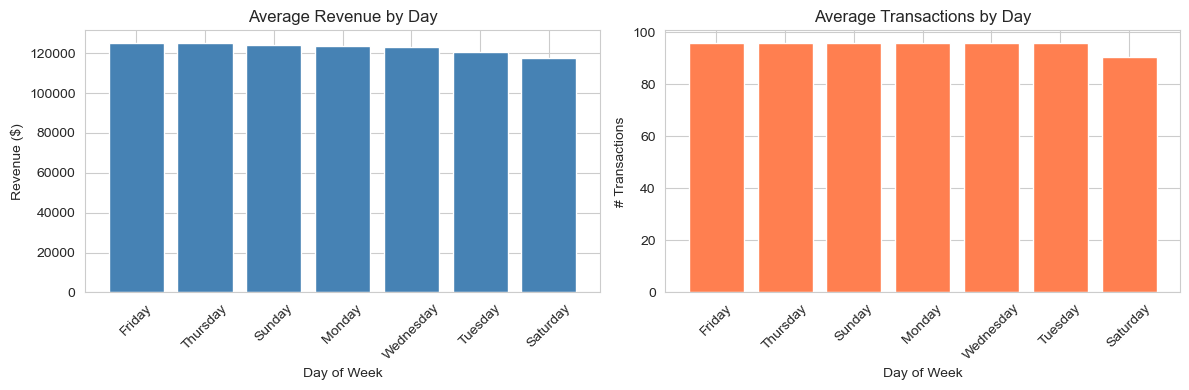


Customer Segmentation Analysis:
  customer_segment  customer_count       avg_ltv
0           Silver             281  12979.356050
1           Bronze             516  12946.284070
2             Gold             203  12638.955025


In [10]:
print("📊 BUSINESS INTELLIGENCE ANALYTICS\n")

# Analysis 1: Sales by Day of Week
day_analysis = pd.read_sql("""
    SELECT 
        day_name,
        AVG(total_revenue) as avg_revenue,
        AVG(num_transactions) as avg_transactions
    FROM agg_daily_sales
    GROUP BY day_name
    ORDER BY avg_revenue DESC
""", warehouse_db)

print("Sales Performance by Day of Week:")
print(day_analysis)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(day_analysis['day_name'], day_analysis['avg_revenue'], color='steelblue')
ax[0].set_title('Average Revenue by Day')
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Revenue ($)')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(day_analysis['day_name'], day_analysis['avg_transactions'], color='coral')
ax[1].set_title('Average Transactions by Day')
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('# Transactions')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analysis 2: Customer Segmentation
segment_analysis = pd.read_sql("""
    SELECT 
        customer_segment,
        COUNT(*) as customer_count,
        AVG(lifetime_value) as avg_ltv
    FROM agg_customer_ltv
    WHERE lifetime_value > 0
    GROUP BY customer_segment
    ORDER BY avg_ltv DESC
""", warehouse_db)

print("\nCustomer Segmentation Analysis:")
print(segment_analysis)

---

## 💾 Part 5: Exporting and Backing Up

### Best Practices: Data Export and Documentation

In [11]:
print("💾 EXPORTING DATABASE CONTENT\n")

# Create export directory
os.makedirs('warehouse_export', exist_ok=True)

# Export key tables
tables_to_export = ['dim_customer', 'dim_product', 'agg_daily_sales']

for table in tables_to_export:
    df = pd.read_sql(f"SELECT * FROM {table}", warehouse_db)
    filename = f'warehouse_export/{table}.csv'
    df.to_csv(filename, index=False)
    print(f"✅ Exported {table}: {len(df)} rows")

# Create summary report
total_revenue = pd.read_sql("SELECT SUM(total_amount) as rev FROM fact_sales", warehouse_db).iloc[0, 0]
total_customers = pd.read_sql("SELECT COUNT(*) as cnt FROM dim_customer", warehouse_db).iloc[0, 0]

summary = f"""
DATA WAREHOUSE SUMMARY
{'='*30}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

Total Revenue: ${total_revenue:,.2f}
Total Customers: {total_customers:,}
Database: data_warehouse.db
"""

with open('warehouse_export/summary.txt', 'w') as f:
    f.write(summary)

print(f"\n📁 Export complete! Files saved in 'warehouse_export/'")
print(summary)

💾 EXPORTING DATABASE CONTENT

✅ Exported dim_customer: 1000 rows
✅ Exported dim_product: 500 rows
✅ Exported agg_daily_sales: 105 rows

📁 Export complete! Files saved in 'warehouse_export/'

DATA WAREHOUSE SUMMARY
Generated: 2025-09-22 17:39

Total Revenue: $12,893,189.50
Total Customers: 1,000
Database: data_warehouse.db



---

## 🎯 Practice Exercises

In [12]:
print("📝 PRACTICE EXERCISES\n")

print("Exercise 1: Create Your Own Pipeline")
print("  • Create 3 related DataFrames")
print("  • Save to a new database")
print("  • Query for insights")
print()

print("Exercise 2: Data Cleaning Challenge")
print("  • Create a messy CSV with various issues")
print("  • Write cleaning functions")
print("  • Import to clean database")
print()

print("Exercise 3: Database Merge")
print("  • Create two separate databases")
print("  • Merge into unified warehouse")
print("  • Create aggregate tables")

📝 PRACTICE EXERCISES

Exercise 1: Create Your Own Pipeline
  • Create 3 related DataFrames
  • Save to a new database
  • Query for insights

Exercise 2: Data Cleaning Challenge
  • Create a messy CSV with various issues
  • Write cleaning functions
  • Import to clean database

Exercise 3: Database Merge
  • Create two separate databases
  • Merge into unified warehouse
  • Create aggregate tables


---

## 🎓 Key Takeaways

You've mastered critical data engineering skills:

1. **DataFrame → SQL**: Convert Python data to persistent databases
2. **CSV → SQL**: Import and clean external data
3. **Database Merging**: Combine multiple sources
4. **Data Warehousing**: Build dimensional models
5. **ETL Pipelines**: Extract, Transform, Load workflows
6. **Data Cleaning**: Handle real-world data issues
7. **Performance**: Create aggregate tables
8. **Export**: Backup and share results

---

## 🚀 Next Steps

You're now ready to:
- Build production data pipelines
- Handle real-world data integration
- Create analytical databases
- Implement ETL processes

**Remember**: This is how real data engineering works!

In [13]:
# Cleanup
company_db.close()
csv_db.close()
warehouse_db.close()

print("✅ All database connections closed.")
print("🎉 Congratulations! You've built a complete data pipeline!")
print("")
print("📊 You created:")
print("  - 3 separate databases")
print("  - 10+ tables")
print("  - 10,000+ records")
print("  - 1 unified data warehouse")
print("")
print("💪 You're now ready for real-world data engineering!")

✅ All database connections closed.
🎉 Congratulations! You've built a complete data pipeline!

📊 You created:
  - 3 separate databases
  - 10+ tables
  - 10,000+ records
  - 1 unified data warehouse

💪 You're now ready for real-world data engineering!
